## Natural Language Autocomplete

In this notebook, we"re going to use transformers to get semantic suggestions for a given term.

In [1]:
import sys
sys.path.append("../..")
from aips import *
from aips.spark import create_view_from_collection
import pandas
import pickle
import json
import tqdm
import spacy
import numpy
from spacy.matcher import Matcher
from IPython.display import display,HTML
from aips import get_engine
from pyspark.sql import SparkSession
import sentence_transformers

engine = get_engine()
pandas.set_option("display.max_rows", 1000)
spark = SparkSession.builder.appName("AIPS").getOrCreate()

## Load and clean the Outdoors dataset

In [2]:
create_view_from_collection(engine.get_collection("outdoors"), "outdoors")
outdoors_dataframe = spark.sql("SELECT * from outdoors")
print(outdoors_dataframe.count())

18456


## Make a vocabulary of all the concepts in a corpus

In [3]:
nlp = spacy.load("en_core_web_sm")

## Listing 13.9

In [4]:
def normalize(span):
    return " ".join([token.lemma_.lower() for token in span])

def yield_tuple(dataframe, column, total):
    total = total or 100
    for idx, row in dataframe.iterrows():
        if idx < total:
            yield (row[column], idx)

def get_concepts(collection, source_field, total=None, load_from_cache=True):
    if load_from_cache:
        os.makedirs(os.path.dirname("data/outdoors/outdoors_concepts.pickle"), exist_ok=True)
        with open("data/outdoors/outdoors_concepts.pickle","rb") as fd:
            concepts = pickle.load(fd)
        with open("data/outdoors/outdoors_labels.pickle","rb") as fd:
            labels = pickle.load(fd)
        return concepts,labels

    #Setting load_from_cache to False will bring you here
    print("Extracting concepts. This could take a while. Take a break and stretch :)")
    create_view_from_collection(collection, "concept_data")
    dataframe = spark.sql("SELECT * FROM concept_data")
        
    #Get all the noun and verb phrases in the content
    phrases = [] #All the normalized noun/verb phrases ("concepts") in the corpus
    sources = [] #The original text labels that was normalized to the concept
    
    #Use the spacy matcher to chunk patterns into concept labels
    #We don't need a full taxonomy graph extraction, just a vocabulary with term frequencies
    matcher = Matcher(nlp.vocab)
    nountags = ["NN", "NNP", "NNS", "NOUN"] #Nouns
    verbtags = ["VB", "VBD", "VBG", "VBN",
                "VBP", "VBZ", "VERB"] #Verbs
    matcher.add("noun_phrases", [[{"TAG": {"IN": nountags},
                                   "IS_ALPHA": True,
                                   "OP": "+"}]])
    matcher.add("verb_phrases", [[{"TAG": {"IN": verbtags},
                                   "IS_ALPHA": True, "OP": "+",
                                   "LEMMA": {"NOT_IN": ["be"]}}]])
    for doc, _ in tqdm.tqdm(nlp.pipe(yield_tuple(dataframe,
                                                 source_field,
                                                 total),
                                     batch_size=40,
                                     n_threads=4,
                                     as_tuples=True),
                             total=total):
        matches = matcher(doc)
        for _, start, end in matches:
            span = doc[start:end]
            phrases.append(normalize(span))
            sources.append(span.text)            
    
    #Aggregate the normalized concepts by term frequency
    concepts = {}
    labels = {}
    for i, phrase in phrases:
        if phrase not in concepts:
            concepts[phrase] = 0
            labels[phrase] = sources[i]
        concepts[phrase] += 1
    
    sorted_concepts = {k: v for k, v in sorted(concepts.items(), key=lambda item: item[1], reverse=True)}
    
    os.makedirs(os.path.dirname("data/outdoors/outdoors_concepts.pickle"), exist_ok=True)
    with open("data/outdoors/outdoors_concepts.pickle","wb") as fd:
        pickle.dump(sorted_concepts, fd)
    with open("data/outdoors/outdoors_labels.pickle","wb") as fd:
        pickle.dump(labels, fd)
    
    return sorted_concepts, labels

## Listing 13.10

### Examining the vocabulary

What are the concepts with the highest frequency?

In [5]:
collection = engine.get_collection("outdoors")
concepts, labels = get_concepts(collection, source_field="body",
                                load_from_cache=True)
topcons = {key: value for (key, value)
           in concepts.items() if value > 5}
print(f"Total number of labels: {len(labels.keys())}")
print(f"Total number of concepts: {len(concepts.keys())}")
print(f"Concepts with greater than 5 term frequency: {len(topcons.keys())}")
print(json.dumps(topcons, indent=2))

Total number of labels: 124366
Total number of concepts: 124366
Concepts with greater than 5 term frequency: 12375
{
  "have": 32782,
  "do": 26869,
  "use": 16793,
  "get": 13412,
  "go": 9899,
  "water": 9537,
  "make": 9476,
  "need": 7814,
  "time": 7187,
  "take": 6550,
  "find": 6359,
  "see": 5591,
  "rope": 5540,
  "know": 5522,
  "day": 5318,
  "way": 5239,
  "want": 5087,
  "people": 5083,
  "keep": 4789,
  "look": 4784,
  "area": 4548,
  "work": 4491,
  "thing": 4451,
  "try": 4179,
  "tent": 4095,
  "bag": 4054,
  "lot": 3934,
  "think": 3728,
  "trail": 3725,
  "say": 3669,
  "foot": 3606,
  "climb": 3559,
  "point": 3550,
  "place": 3539,
  "question": 3424,
  "help": 3206,
  "come": 3186,
  "put": 3115,
  "hike": 3042,
  "weight": 3034,
  "fall": 3027,
  "start": 3009,
  "leave": 2977,
  "answer": 2949,
  "give": 2945,
  "something": 2926,
  "food": 2907,
  "year": 2864,
  "carry": 2823,
  "pack": 2755,
  "end": 2752,
  "one": 2741,
  "bear": 2738,
  "fire": 2730,
  "bod

## Transformer time!

In [6]:
from sentence_transformers import SentenceTransformer
transformer = SentenceTransformer("roberta-base-nli-stsb-mean-tokens")
cache_name = "outdoors_embeddings"

## Listing 13.11

In [7]:
def get_embeddings(texts, cache_name, ignore_cache=False):
    cache_file_name = f"data/embeddings/{cache_name}.pickle"
    if ignore_cache or not os.path.isfile(cache_file_name):
        embeddings = transformer.encode(texts)
        os.makedirs(os.path.dirname(cache_file_name), exist_ok=True)
        with open(cache_file_name, "wb") as fd:
            pickle.dump(embeddings, fd)
    else:
        with open(cache_file_name, "rb") as fd:
            embeddings = pickle.load(fd)
    return embeddings

In [8]:
#Note!  This is a hyperparameter.
#We are ignoring terms that occur less than this numner in the entire corpus.
#Lowering this number may lower precision
#Raising this number may lower recall
minimum_frequency = 6
phrases = [key for (key, tf) in concepts.items() if tf >= minimum_frequency]
#set ignore_cache=True to regenerate the embeddings rather than loading from the cache
embeddings = get_embeddings(phrases, cache_name, ignore_cache=False)

print(f"Number of embeddings: {len(embeddings)}")
print(f"Dimensions per embedding: {len(embeddings[0])}")

Number of embeddings: 12375
Dimensions per embedding: 768


## Listing 13.12

### Explore the top similarities for the top terms

In [9]:
def normalize_embedding(embedding):
    normalized = numpy.divide(embedding, numpy.linalg.norm(embedding))
    return list(map(float, normalized))

In [63]:
def rank_similarities(phrases, similarities):
    a_phrases = []
    b_phrases = []
    scores = []
    for a in range(len(similarities) - 1):
        for b in range(a + 1, len(similarities)):
            a_phrases.append(phrases[a])
            b_phrases.append(phrases[b])
            scores.append(float(similarities[a][b]))
    dataframe = pandas.DataFrame({"score": scores,
                                  "phrase a": a_phrases, "phrase b": b_phrases})
    dataframe["idx"] = range(len(dataframe))
    dataframe = dataframe.reindex(columns=["idx", "score", "phrase a", "phrase b"])
    return dataframe.sort_values(by=["score"], ascending=False,
                                    ignore_index=True)

In [68]:
#Find the pairs with the highest cosine similarity scores
normalized_embeddings = list(map(normalize_embedding, embeddings))
similarities = sentence_transformers.util.dot_score(
    normalized_embeddings[0:250],
    normalized_embeddings[0:250])
comparisons = rank_similarities(phrases, similarities)
display(HTML(comparisons[:10].to_html(index=False)))

idx,score,phrase a,phrase b
31096,0.928151,protect,protection
13241,0.923570,climbing,climber
18096,0.878894,camp,camping
7282,0.833662,climb,climbing
10312,0.821081,something,someone
8813,0.815187,hike,hiking
4182,0.784663,people,person
7354,0.782962,climb,climber
1027,0.770643,go,leave
4422,0.768611,keep,stay


## Listing 13.13

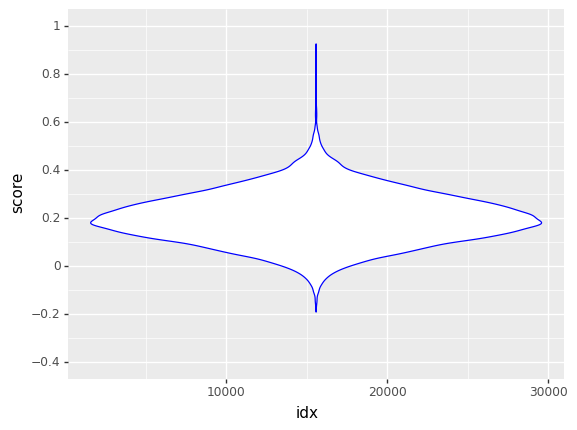

{<ggplot: (8774532596688)>}

In [69]:
from plotnine import *
candidate_synonyms = comparisons[comparisons["score"] > 0.0]
{
    ggplot(comparisons, aes("idx", "score")) + 
    geom_violin(color="blue") +
    scale_y_continuous(limits=[-0.4, 1.0],
                       breaks=[-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0])
}

## Listing 13.14

### Quickly matching vectors at query time

Now that we can get and compare concept embeddings, we need to be able to search these embeddings efficiently.

In [12]:
import nmslib
# initialize a new index, using a HNSW index on Dot Product
concepts_index = nmslib.init(method="hnsw",
                             space="negdotprod")
normalized_embeddings = list(map(normalize_embedding, embeddings))
concepts_index.addDataPointBatch(normalized_embeddings)
concepts_index.createIndex(print_progress=True)

# Example query for the new index.  The 25th embedding is the term "bag"
ids, _ = concepts_index.knnQuery(
    normalized_embeddings[25], k=10)
matches = [labels[phrases[i]].lower() for i in ids]
display(matches)

['bag', 'bag ratings', 'bag cover', 'bag liner', 'garbage bags', 'wag bags', 'bag cooking', 'airbag', 'paper bag', 'tea bags']


## Listing 13.15

In [ ]:
def print_labels(prefix,matches):
    display(HTML(f"<h4>Results for: <em>{prefix}</em></h4>"))
    for (l, d) in matches:
        print(str(int(d * 1000) / 1000), "|", l)

In [13]:
def embedding_search(index, query, phrases, k=20, min_similarity=0.75):
    matches = []
    query_embedding = transformer.encode(query)
    query_embedding = normalize_embedding(query_embedding)
    ids, distances = index.knnQuery(query_embedding, k=k)
    for i in range(len(ids)):
        distance = distances[i] * -1
        if distance > min_similarity:
            matches.append((phrases[ids[i]], distance))
    if not len(matches):
        matches.append((phrases[ids[1]], distances[1] * -1))
    return matches

def semantic_suggest(prefix, phrases):
    matches = embedding_search(concepts_index, prefix, phrases)
    print_labels(prefix, matches)

In [14]:
semantic_suggest("mountain hike", phrases)

1.0 | mountain hike
0.975 | mountain hiking
0.847 | mountain trail
0.787 | mountain guide
0.779 | mountain terrain
0.775 | mountain climbing
0.768 | mountain ridge
0.754 | winter hike


In [15]:
semantic_suggest("campfire", phrases)

1.0 | campfire
0.956 | camp fire
0.928 | campfire impact
0.865 | camping fuel
0.823 | camping stove
0.796 | camp stove
0.775 | cooking fire
0.774 | campground
0.764 | fireplace
0.759 | camping area
0.755 | have camp


In [16]:
semantic_suggest("dehyd", phrases)

0.941 | dehydrate
0.931 | dehydration
0.852 | rehydration
0.851 | dehydrator
0.836 | hydration
0.835 | hydrating
0.822 | rehydrate
0.812 | hydrate
0.788 | hydration pack
0.776 | hydration system


In [17]:
semantic_suggest("compa", phrases)

0.863 | comp
0.829 | compact
0.803 | compile
0.792 | compost
0.786 | compass
0.778 | competitor
0.765 | competence
0.758 | compactor
0.755 | compare


## Addendum: Bias Excercise
These cells enable exploration for detecting similarity/context bias that may exist in a model

In [18]:
def build_candidate_set(cons):
    terms = list(cons.keys())
    originals = []
    candidates = []
    scores = []
    for term in tqdm.tqdm(terms[0:1000]):
        labels = embedding_search(concepts_index, term, phrases=terms, k=25)
        originals += [term] * len(labels)
        candidates += [l[0] for l in labels]
        scores += [l[1] for l in labels]
    pairs = pandas.DataFrame({"term": originals, "candidate": candidates, "score":scores})
    return pairs

In [19]:
pairs = build_candidate_set(topcons)
pairs.to_csv("pairs.csv")

100%|██████████| 1000/1000 [00:22<00:00, 44.36it/s]


In [20]:
#Compare a list of terms
def compare(terms):

    term_embeddings = transformer.encode(terms, convert_to_tensor=True)
    
    a_phrases = []
    b_phrases = []
    scores = []
    for a in range(len(terms) - 1):
        for b in range(a + 1, len(terms)):
            a_phrases.append(terms[a])
            b_phrases.append(terms[b])
            sim = sentence_transformers.util.pytorch_cos_sim(
                term_embeddings[a], term_embeddings[b])
            scores.append(float(sim))

    comparisons = pandas.DataFrame({"phrase a": a_phrases, "phrase b": b_phrases,
                                    "score": scores, "name": "similarity"})
    comparisons = comparisons.sort_values(by=["score"], ascending=False, ignore_index=True)
    return comparisons

In [21]:
#Gender-occupational bias example
#Note the similarity scores for gender and occupation 
compare(["man", "woman", "nurse practitioner", "doctor"])

,phrase a,phrase b,score,name
0,nurse practitioner,doctor,0.488934,similarity
1,man,woman,0.280403,similarity
2,woman,nurse practitioner,0.179482,similarity
3,man,doctor,0.084211,similarity
4,woman,doctor,0.028788,similarity
5,man,nurse practitioner,-0.030063,similarity


## Addendum: Vector Space Visualization Figure 13.6
This cell uses Principal Component Analysis (PCA) to reduce embeddings to 3 dimensions so they can be plotted in 3d.

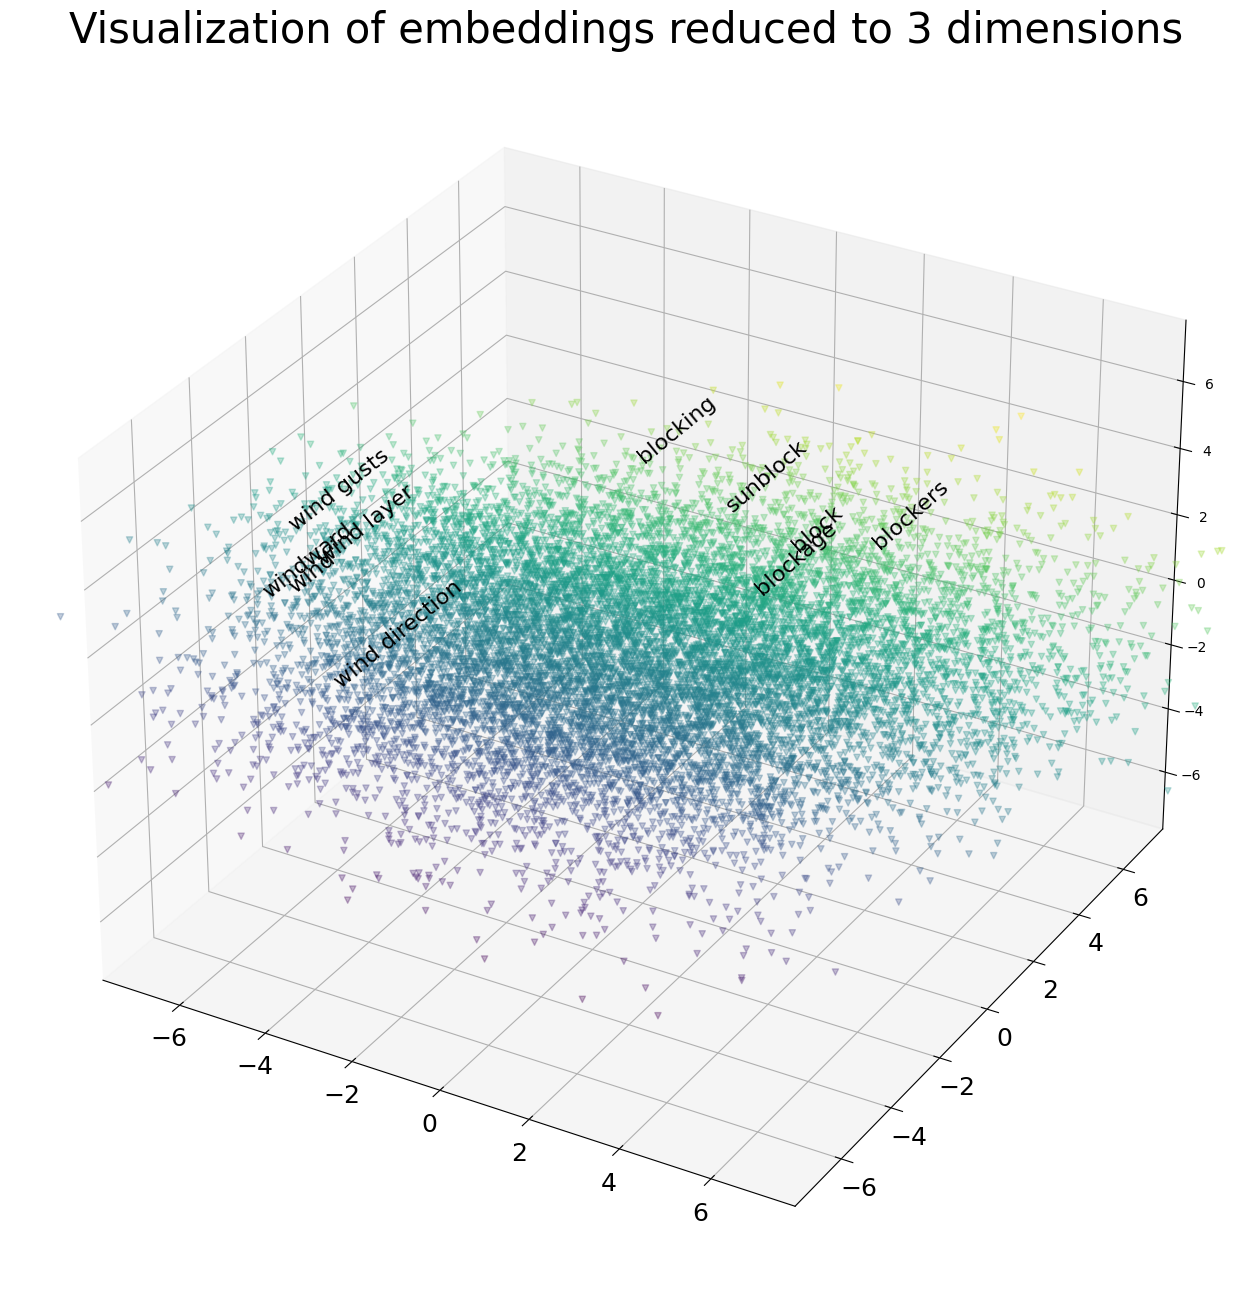

In [22]:
%matplotlib inline
import numpy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
vectors = numpy.array(embeddings)
pca = PCA(n_components=3)
pca_data = pca.fit_transform(vectors)

label_ids = []
label_texts = []
ids,_ = concepts_index.knnQuery(embeddings[100], k=5)
label_ids += [idx for idx in ids]
ids,_ = concepts_index.knnQuery(embeddings[505], k=5)
label_ids += [idx for idx in ids]
label_texts += [labels[phrases[idx]].lower() for idx in label_ids]
markers = ["v"]*len(vectors)

components = pandas.DataFrame({
    "x": pca_data[:,0],
    "y": pca_data[:,1],
    "z": pca_data[:,2]
})

fig = plt.figure(figsize=(24,16))
ax = fig.add_subplot(projection="3d")
ax.scatter(
    components["x"].values, 
    components["y"].values, 
    c=components["y"].values, 
    marker="v", 
    alpha=0.3
)

for i,label in zip(label_ids,label_texts):
    x = components["x"][i]
    y = components["y"][i]
    z = components["z"][i]
    zdir = "y"
    ax.text(x, y, z, label, zdir, fontsize=16)

ax.set_xlim(-7.5, 7.5)
ax.set_ylim(-7.5, 7.5)
ax.set_zlim(-7.5, 7.5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)
ax.set_title('Visualization of embeddings reduced to 3 dimensions', fontsize=30) # increase or decrease y as needed
plt.show()

## Addendum: Find topic vector centroids with KMeans

In [23]:
from torch import stack as  torch_stack
from sklearn.cluster import KMeans

def semanticnearest(embeddings,k=20):
    matches = []
    ids, distances = concepts_index.knnQuery(embeddings, k=k)
    for i in range(len(ids)):
        text = phrases[ids[i]]
        dist = distances[i] * -1
        if dist>0.6:
            matches.append((ids[i], text, dist))
    if not len(matches):
        matches.append(([ids[1]], phrases[ids[1]], dist))
    return matches

In [24]:
def findcentroids(embeddings, n_clusters=8, max_iter=300):
    centroids = []
    centroid_embeddings = []
    vectors = numpy.array(embeddings)
    kmeans = KMeans(n_clusters=n_clusters, random_state=505, max_iter=max_iter).fit(vectors)
    for centroid in kmeans.cluster_centers_:
        matches = semanticnearest(centroid,k=5)
        centroids.append(matches[0])
        centroid_embeddings.append(embeddings[matches[0][0]])
        display(HTML(f"<h4>Results for: <em> centroid {str(len(centroids)-1)}</em></h4>"))
        for i,l,d in matches:
            if l in labels.keys():
                l = labels[l].lower()
            print(str(i) + "\t" + l + "\t" + str(d))
    
    return centroids,torch_stack(centroid_embeddings)

In [25]:
centroids, centroid_embeddings = findcentroids(embeddings, n_clusters=100,  max_iter=50)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


131	dogs	7.202284336090088
10705	dog sled	6.981184005737305
10673	dog attacks	6.898977756500244
96	animals	6.876914978027344
8601	dogs	6.858933448791504


1718	shotgun	10.554573059082031
742	guns	10.41041374206543
6615	gunshot	10.267881393432617
7451	shotgun shells	10.0164213180542
10150	gun season	9.789477348327637


2865	gauge	10.025125503540039
641	g	10.013925552368164
8974	gaia gps	9.726096153259277
12260	gander	9.609747886657715
7024	grog	9.473861694335938


11447	rope systems	8.5319185256958
12141	rope friction	8.061320304870605
4046	rope stretch	7.946591854095459
4719	persist	7.910519599914551
12	rope	7.899091720581055


5619	buying	9.335536003112793
4422	buyer	8.779233932495117
685	purchasing	8.740710258483887
110	buying	8.615089416503906
7334	price tag	8.514827728271484


770	skiing	13.910954475402832
9471	ski slope	13.818438529968262
1557	skier	13.469791412353516
153	skiing	13.37520980834961
9050	at skis	13.363271713256836


6266	moisten	9.49377727508545
11909	moat	9.455950736999512
7202	moisture content	9.392165184020996
6658	moisturizer	9.33210563659668
442	moisture	9.328527450561523


2413	extension	10.187589645385742
2098	e	9.887519836425781
5884	expel	9.835672378540039
2175	exerting	9.564743995666504
10636	engraved	9.550605773925781


2667	electronics	7.6952056884765625
4598	embedded	7.5393385887146
5225	conductor	7.490269660949707
10060	experience level	7.450250625610352
10404	skyline	7.434004783630371


2602	n	10.422712326049805
7539	ne	10.200583457946777
11971	nestled	9.536375999450684
4107	ny	9.534656524658203
10024	nts	9.486237525939941


7250	carbonate	9.630046844482422
785	carbon	9.44959545135498
2182	coconut	9.162171363830566
10635	coconut shell	9.153450012207031
5863	caribiners	9.063810348510742


6103	sw	11.300243377685547
493	swim	11.197742462158203
10922	swift	10.923288345336914
7221	swat	10.756399154663086
10037	swipe	10.712603569030762


2033	wilderness area	10.595848083496094
309	wilderness	10.479524612426758
9559	wilderness trip	10.037864685058594
10394	wild country	9.926725387573242
9437	wilderness permit	9.866880416870117


4712	field guides	7.926677703857422
4693	game trail	7.728925704956055
389	field	7.502997875213623
7460	field points	7.29960823059082
10270	field test	7.148768424987793


541	hammocks	7.651044845581055
11250	hammock systems	7.645929336547852
2241	maple	7.508709907531738
8191	hammocking	7.25922155380249
886	mat	7.243190765380859


60	climbing	13.164630889892578
4160	climbing wall	12.839048385620117
6205	climbing grades	12.708711624145508
8884	climbing style	12.626376152038574
9219	climbing trip	12.469368934631348


898	b	9.790145874023438
11190	ba	9.470158576965332
3410	barb	9.402612686157227
4003	bacon	9.173323631286621
2916	ben	9.146050453186035


287	emergency	15.539041519165039
3850	emergency services	15.415409088134766
7038	emergency use	15.226373672485352
11129	emergency response	15.135271072387695
9775	emergency number	14.996847152709961


5206	logo	8.232942581176758
4070	ligaments	7.999628067016602
11921	sorels	7.9867753982543945
7585	lesions	7.907844066619873
1439	l	7.808502197265625


90	temperature	9.713693618774414
3460	temperature rating	9.349380493164062
3287	temperature range	9.343667984008789
11632	temperature gradients	9.3272123336792
3474	sensations	9.184555053710938


11542	dnt	9.948341369628906
1852	d	9.916374206542969
7002	delorme	9.892783164978027
4547	dent	9.861241340637207
9735	duo	9.452152252197266


2801	j	7.698341369628906
11481	jb	7.479821681976318
10358	jostled	7.2790207862854
2213	journal	7.272130966186523
4944	jerk	7.258995056152344


721	re	10.31106948852539
1396	r	9.843616485595703
4089	reps	9.775282859802246
2665	residue	9.693038940429688
12307	reserved	9.647812843322754


12055	oxygen bottles	10.047792434692383
6776	pop bottles	9.621797561645508
9303	squeeze bottle	9.461040496826172
6929	spray bottle	9.290040016174316
11133	liter bottle	9.257987976074219


5101	safety precaution	13.653962135314941
183	safety	13.625102996826172
9273	safety aspect	13.422151565551758
6378	safety measures	13.293819427490234
8949	safety system	13.178617477416992


11263	belay carabiner	9.80412483215332
1388	boar	9.76162338256836
3854	bob	9.589390754699707
6880	battery acid	9.535433769226074
7442	blob	9.444320678710938


84	mountains	13.886868476867676
11653	mountain region	13.680323600769043
5184	mountain national	13.451791763305664
6987	mountain area	13.449374198913574
7808	mountain project	13.196228981018066


7891	life expectancy	10.473709106445312
6603	retirement	10.258148193359375
11187	elder	9.988204956054688
4859	longevity	9.986684799194336
9586	retie	9.942484855651855


941	have done	9.696748733520508
0	have	9.597739219665527
11959	remember having	9.555818557739258
6587	seen have	9.548416137695312
881	have had	9.543233871459961


4943	erring	8.892302513122559
1396	r	8.75092887878418
4404	reeds	8.349804878234863
5457	roaring	8.083988189697266
9163	ruff	8.05630111694336


2190	tangled	8.252544403076172
8398	entangled	7.718593597412109
3692	dangling	7.634808540344238
8726	diameter rope	7.626504421234131
5543	friction knot	7.612905502319336


52	bears	14.806414604187012
8149	bear territory	14.10173225402832
6637	bear boxes	13.775826454162598
2144	bear country	13.71654987335205
6804	bear bangers	13.46855640411377


7849	rock type	8.671838760375977
10468	red rock	8.659749031066895
63	rock	8.598150253295898
8777	rock salt	8.447105407714844
3123	rocker	8.34809684753418


4603	explosion	9.463373184204102
4288	geography	9.453271865844727
7758	geographical region	9.348190307617188
4913	geographic	9.323238372802734
2138	erosion	9.262587547302246


7223	laurel	9.473230361938477
5528	lukla	9.23269271850586
5798	lint	8.762743949890137
8288	luke	8.746407508850098
10929	laos	8.598018646240234


205	increased	12.249338150024414
3651	enhance	11.610806465148926
2362	high	11.564815521240234
3891	succeed	11.510568618774414
6567	increments	11.343681335449219


1928	h	8.869744300842285
10503	hutte	8.322912216186523
11818	hasten	8.276847839355469
7088	hwy	8.273399353027344
4827	hace	8.255081176757812


278	north	10.71541690826416
3848	north face	10.382608413696289
9365	northface	10.334970474243164
12301	northwest face	10.134302139282227
2815	northwest	10.113344192504883


12012	underneath	8.668103218078613
758	lowering	8.641229629516602
10134	under	8.573155403137207
4901	designation	8.49024772644043
182	level	8.489255905151367


53	fire	12.590879440307617
8855	fire risk	11.675952911376953
9178	fire way	11.5858736038208
6248	stove fuel	11.452194213867188
12335	firelighter	11.447981834411621


539	f	9.455723762512207
12051	fcrf	9.207575798034668
4221	fir	8.866588592529297
7864	firn	8.802047729492188
7175	fusion	8.787566184997559


332	training	10.118284225463867
9500	training courses	9.992923736572266
8551	training program	9.954814910888672
11182	training sessions	9.831062316894531
8926	has taught	9.251700401306152


613	trouble	9.234315872192383
65	problem	9.036727905273438
8607	bear problems	8.463531494140625
3101	conflicting	8.322455406188965
242	damage	8.290669441223145


9384	sc	9.989335060119629
1112	s	9.943717002868652
8051	subsets	9.43000602722168
9077	scenic	9.418745994567871
6519	sss	9.380575180053711


4319	decompose	9.731101989746094
6516	drones	9.541138648986816
4250	drowning	9.488265991210938
6964	dwelling	9.468341827392578
1230	down	9.423816680908203


2953	sea kayak	10.442506790161133
9957	water boat	10.045516967773438
2188	sailboat	9.846017837524414
7004	fishing kayak	9.845160484313965
7082	kayak paddle	9.687015533447266


1542	consequences	10.036956787109375
1434	concentration	9.906898498535156
6763	contraction	9.775528907775879
9767	consent	9.718772888183594
10166	contraptions	9.686477661132812


1441	polyester	9.320024490356445
10847	penknife	9.313180923461914
4355	polypro	9.210693359375
32	point	9.159640312194824
2549	penetrates	9.101781845092773


542	mm	9.363068580627441
257	m	9.286468505859375
6851	multi	8.812044143676758
949	mass	8.716011047363281
1528	mid	8.423519134521484


46	food	11.063398361206055
10547	food preparation	10.941784858703613
7376	food items	10.809882164001465
8240	food prep	10.547788619995117
11722	food pack	10.515373229980469


7036	fl	10.165380477905273
1738	flares	9.854690551757812
7175	fusion	9.25985336303711
2361	flavors	9.0924654006958
9636	flatness	9.082319259643555


2079	has got	10.233407974243164
8061	try getting	10.16250228881836
3	getting	10.021723747253418
6860	go getting	9.933598518371582
7650	suggest getting	9.786581039428711


866	considerations	9.831985473632812
6446	reconsider	9.465238571166992
92	considering	9.347210884094238
4080	interpretations	9.3399019241333
5079	speculation	8.998053550720215


3471	concealed	8.737903594970703
9994	caverns	8.697080612182617
5081	cocoon	8.689659118652344
8088	crocs	8.509123802185059
10399	coconino	8.503805160522461


11134	ssp	8.930112838745117
4601	spores	8.731584548950195
1538	spine	8.727005004882812
3987	spices	8.68503189086914
10508	sep	8.630928993225098


6570	walking shoes	10.77292537689209
4594	walking boots	10.523372650146484
3154	footpath	10.479982376098633
30	feet	10.467926025390625
6397	footsteps	10.333290100097656


10456	nice	11.336792945861816
3099	cleaner	11.12735652923584
369	clean	11.11158275604248
1513	ease	10.689395904541016
1261	clear	10.642156600952148


9803	do keep	10.08813190460205
1988	withstands	9.842982292175293
126	avoid	9.741962432861328
11390	does stay	9.684378623962402
5366	have keeping	9.653000831604004


2856	alberta	6.9250688552856445
1954	assist	6.894824981689453
3763	ass	6.867303848266602
6679	atlas	6.8335089683532715
11340	assateague	6.818901538848877


2722	evolved	11.39335823059082
1336	differ	11.257879257202148
6076	relocation	11.228973388671875
3698	differentiates	11.015663146972656
6899	diffuse	10.656407356262207


6684	trail system	11.08642292022705
8176	trails	10.623128890991211
6527	trail map	10.588077545166016
28	trail	10.540056228637695
11621	trailing	10.332484245300293


3360	cellphone	13.396879196166992
377	phone	13.334859848022461
5537	telephone	13.294726371765137
1747	cell phone	13.275378227233887
6789	cell phone coverage	13.201822280883789


285	rest	11.63571834564209
11333	resting	11.593923568725586
5319	ve slept	11.372343063354492
10115	sleeping area	11.249914169311523
2313	retreating	11.139753341674805


3958	blanc	9.46276569366455
7871	blake	8.715197563171387
8988	bloqueurs	8.473636627197266
3538	breast	8.378552436828613
7466	blubber	8.360183715820312


10466	handwashing	10.043991088867188
11868	dishwashing	9.993985176086426
7146	scrubbing	9.783943176269531
1514	wipes	9.738744735717773
10465	rinsing	9.73476791381836


12093	national park system	11.43934440612793
622	national park	11.319280624389648
114	park	11.244245529174805
11594	park area	11.12055778503418
2172	national park service	11.041877746582031


262	c	9.516639709472656
3171	cdc	9.170554161071777
2204	carcass	8.874223709106445
1377	calculate	8.678569793701172
6268	camber	8.630975723266602


2913	digest	9.53836441040039
3621	digestion	9.502500534057617
683	dig	8.878658294677734
8058	ingestion	8.682872772216797
7144	digging	8.323848724365234


9204	rubble	10.60948657989502
691	rubber	10.4334135055542
1615	bubbles	9.770304679870605
4792	rubbish	9.75607967376709
4728	ribbon	9.402986526489258


4103	insight	10.797548294067383
9587	viewer	10.605657577514648
5620	viewing	10.555787086486816
7240	eyesight	10.201614379882812
553	view	10.027345657348633


2245	w	9.948518753051758
11220	wy	9.634571075439453
12166	wren	9.633056640625
802	west	9.627591133117676
5826	wa	9.530226707458496


2660	dispersed	12.895134925842285
3344	displaced	12.81641960144043
1750	get rid	12.80908203125
7969	withdrawal	12.789698600769043
5593	disregard	12.743925094604492


1402	v	10.519464492797852
5870	va	10.516250610351562
1502	valve	10.311351776123047
2139	van	10.076641082763672
704	uv	10.075417518615723


12086	transducers	10.660405158996582
2970	transmission	10.288772583007812
2056	translate	9.952665328979492
3659	elevation changes	9.92959976196289
5268	flotation device	9.866744041442871


3472	k	9.411072731018066
7389	ken	8.773683547973633
11750	karen	8.439525604248047
10048	kso	8.325142860412598
2321	kerosene	8.324383735656738


11079	survival scenario	13.036870956420898
1498	survival situation	12.920746803283691
6385	survivalist	12.881462097167969
365	survival	12.779830932617188
9183	survival techniques	12.533844947814941


4821	tract	7.53541898727417
6730	tribes	7.497117519378662
1722	trousers	7.4969282150268555
10264	tarptent	7.48858642578125
9696	trapezoid	7.478793144226074


1128	t	10.665961265563965
8745	tent design	10.545835494995117
24	tent	10.51859188079834
8683	tent material	10.488451957702637
11022	tso	10.376842498779297


11720	meetup	9.583074569702148
615	meet	9.338064193725586
2550	organize	9.182626724243164
7582	has gathered	9.060613632202148
3274	assemble	8.941858291625977


41	start	13.273859977722168
4157	have started	13.052827835083008
4170	get started	13.048385620117188
578	begins	12.95766544342041
1574	beginning	12.837370872497559


1109	sunlight	12.39186954498291
11942	sun light	12.189828872680664
5056	sunshine	12.07876968383789
9592	sun exposure	12.011878967285156
305	sun	11.953449249267578


5	water	13.832379341125488
7458	water systems	13.799169540405273
9093	watering	13.742570877075195
6294	water flow	13.349417686462402
8322	water filtration	13.294500350952148


2248	york	10.337481498718262
1909	y	10.183905601501465
9145	york state	10.109270095825195
10972	york city	9.901330947875977
2381	new york	9.674808502197266


9900	pipistrelle	9.441424369812012
10575	pooping	9.161179542541504
8932	pus	9.07059097290039
8382	prepping	9.046018600463867
5761	pp	9.033010482788086


408	plastic	8.139122009277344
11076	plastic sheet	8.031190872192383
4364	physiology	7.692321300506592
4578	peroxide	7.683289527893066
8282	metal frame	7.628844261169434


5277	overloading	10.303790092468262
7231	load bearing	9.557626724243164
209	load	9.524032592773438
10410	carrying capacity	9.51455307006836
5617	overuse	9.208651542663574


1701	hiking trails	13.280275344848633
11587	hiking paths	13.132630348205566
93	hiking	12.868417739868164
3025	hiking trip	12.842009544372559
8955	hiking routes	12.796714782714844


5610	camping area	15.190397262573242
4416	camping sites	15.111692428588867
101	camping	15.093731880187988
10206	camping place	15.08108901977539
4735	camping spot	14.929733276367188


7828	air force	10.865849494934082
3081	aircrafts	10.84202766418457
2723	airplanes	10.71068000793457
95	air	10.691520690917969
8746	air exchange	10.64330005645752


3103	arrangement	9.732755661010742
7662	signifies	9.424543380737305
4958	enclosure	9.127311706542969
4281	assigned	9.091204643249512
430	according	9.066680908203125


59	snow	11.469072341918945
2083	freezing	11.459644317626953
9459	snow level	11.35604190826416
8369	icefall	11.338672637939453
135	winter	11.184362411499023


6972	gadget	9.470024108886719
10019	geotags	9.370454788208008
1517	garbage	9.288827896118164
10932	geotagged	9.280434608459473
10020	geotagging	9.207847595214844


9864	body types	15.1379976272583
54	body	15.024589538574219
5759	body position	14.931316375732422
7407	body temp	14.880573272705078
7005	body mass	14.803720474243164


8199	rescue situations	11.610692024230957
9058	rescue work	11.48339557647705
255	rescue	11.479593276977539
6552	rescue techniques	10.98760986328125
4987	rescue service	10.957934379577637


5292	compact	8.695096969604492
7413	clutch	8.529451370239258
9451	ch	8.507345199584961
1081	compress	8.34837818145752
10502	compactor	8.342792510986328


61	tree	11.266782760620117
4487	tree branches	11.26427173614502
9226	tree cover	11.119697570800781
9533	trees limbs	11.010275840759277
12089	tree stumps	10.988394737243652


1997	weather conditions	11.689956665039062
10245	weathering	11.55788803100586
2697	weather forecast	11.440242767333984
109	weather	11.413013458251953
6840	weather reports	11.348491668701172


10921	proper	9.751601219177246
8285	prevalence	9.372764587402344
2585	propose	9.364072799682617
2983	p	9.196404457092285
8382	prepping	8.951501846313477


1880	in	8.36552619934082
4715	initiate	8.175365447998047
2183	ii	7.977560520172119
3801	ie	7.850099563598633
4190	id	7.800360679626465


6371	inhabitants	9.827348709106445
187	couple	9.52784252166748
2606	relationship	9.188905715942383
760	partner	8.994864463806152
4838	couple years	8.96700668334961


TypeError: expected Tensor as element 0 in argument 0, but got numpy.ndarray

In [ ]:
print(centroids)
print(centroid_embeddings)

[(10466, 'handwash', 0.8039088249206543), (150, 'backpack', 0.789563775062561), (80, 'ice', 0.8592484593391418), (11915, 'canvas tarp', 0.722813606262207), (1880, 'in', 0.7571237087249756), (6103, 'sw', 0.8860063552856445), (1852, 'd', 0.8285518884658813), (2602, 'n', 0.8527299761772156), (8521, 'plateaus', 0.756929874420166), (6062, 'weather change', 0.8357369899749756), (4103, 'insight', 0.8352082371711731), (3763, 'ass', 0.7401955127716064), (8926, 'have teach', 0.7313310503959656), (12166, 'wren', 0.8052818775177002), (10456, 'nice', 0.8788074851036072), (7202, 'moisture content', 0.8020135164260864), (9900, 'pipistrelle', 0.8525463342666626), (7229, 'base weight', 0.7779852747917175), (9957, 'water boat', 0.8313672542572021), (4020, 'daytime', 0.8735556602478027), (4866, 'discontinue', 0.8149714469909668), (9994, 'cavern', 0.7767986059188843), (6603, 'retirement', 0.8234813213348389), (1538, 'spine', 0.8231596946716309), (8227, 'strangle', 0.7923411726951599), (18, 'keep', 0.85979

In [ ]:
normalized_centroid_embeddings = list(map(normalize_embedding, embeddings))
similarities = sentence.dot_score(normalized_centroid_embeddings, normalized_centroid_embeddings)
print("The shape of the resulting similarities:", similarities.shape)

The shape of the resulting similarities: torch.Size([100, 100])


### KMeans Topic distribution

This cell below shows good distribution of similarity scores for our topics.

In [ ]:
import pandas

a_phrases = []
b_phrases = []
scores = []

for a in range(len(similarities)-1):
    for b in range(a+1, len(similarities)):
        a_phrases.append(centroids[a][1])
        b_phrases.append(centroids[b][1])
        scores.append(float(similarities[a][b]))

df = pandas.DataFrame({"phrase a": a_phrases, "phrase b": b_phrases, "score":scores})
df.sort_values(by=["score"], ascending=False, ignore_index=True)

,phrase a,phrase b,score
0,revise,increment,0.723681
1,wren,wy,0.713014
2,b,bacon,0.671149
3,temperature,heat,0.666397
4,start,new,0.664019
...,...,...,...
4945,sw,monoxide,-0.149354
4946,camping area,t,-0.173272
4947,camping area,oxygen bottle,-0.177567
4948,start,have sleep,-0.190825


Up next: [Semantic Search with Dense Vector Embeddings](4.semantic-search.ipynb)